In [1]:
# NOTE: export SPARK_DRIVER_MEMORY=1g

In [2]:
import keras
from keras.applications import ResNet50
from keras.applications import imagenet_utils

# For resnet, we only support NCHW and Keras 1.2.2 for now
keras.backend.set_image_dim_ordering("th")

keras_model = ResNet50(weights="imagenet")

from bigdl.keras.backend import *
from bigdl.transform.vision.image import *

redire_spark_logs()
show_bigdl_info_logs()
init_engine()

# remove setMaster on cluster mode
sparkConf = create_spark_conf().setMaster("local[4]").setAppName("test model")
sc = get_spark_context(sparkConf)

# Load a Keras definition
bmodel = DefinitionLoader.from_kmodel(keras_model)
# Dump weights from kears model to BigDL
WeightLoader.load_weights_from_kmodel(bmodel, keras_model)

# We can pass in a HDFS path into read method.
image_frame = ImageFrame.read("file:////opt/bigdl/act/notebooks/part4/image-net", sc=sc)

transformer = Pipeline([BytesToMat(), Resize(256, 256),
                        CenterCrop(224, 224),
                        ChannelNormalize(123.68, 103.939, 116.779),
                        MatToTensor(), ImageFrameToSample()])
# you can use bmodel.predict(samples: RDD[Sample]) here as well.
preds_frame = bmodel.predict_image(image_frame.transform(transformer))


Using TensorFlow backend.
/root/miniconda2/envs/py2bigdl/lib/python2.7/site-packages/keras/applications/resnet50.py:231: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image dimension ordering convention (`image_dim_ordering="th"`). For best performance, set `image_dim_ordering="tf"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


Using /opt/bigdl/spark-1.6.3-bin-hadoop2.6
Adding /opt/bigdl/bigdl-0.5.0-spark1.6.3/lib/bigdl-SPARK_1.6-0.5.0-jar-with-dependencies.jar to BIGDL_JARS
Adding /opt/bigdl/bigdl-0.5.0-spark1.6.3/lib/bigdl-SPARK_1.6-0.5.0-jar-with-dependencies.jar to SPARK_CLASSPATH
creating: createInput
creating: createSequential
creating: createPadding
creating: createPadding
creating: createPadding
creating: createPadding
creating: createSpatialConvolution
creating: createXavier
creating: createZeros
creating: createSpatialBatchNormalization


/opt/bigdl/bigdl-0.5.0-spark1.6.3/lib/bigdl-0.5.0-python-api.zip/bigdl/keras/converter.py:791: UserWarning: Cannot find dim_ordering from json definition. Using the default instead.


creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createXavier
creating: createZeros
creating: createSpatialBatchNormalization
creating: createReLU
creating: createSpatialConvolution
creating: createXavier
creating: createZeros
creating: createSpatialBatchNormalization
creating: createReLU
creating: createSpatialConvolution
creating: createXavier
creating: createZeros
creating: createSpatialConvolution
creating: createXavier
creating: createZeros
creating: createSpatialBatchNormalization
creating: createSpatialBatchNormalization
creating: createCAddTable
creating: createReLU
creating: createSpatialConvolution
creating: createXavier
creating: createZeros
creating: createSpatialBatchNormalization
creating: createReLU
creating: createSpatialConvolution
creating: createXavier
creating: createZeros
creating: createSpatialBatchNormalization
creating: createReLU
creating: createSpatialConvolution
creating: createXavier
creating: createZeros
cr

In [3]:
preds = preds_frame.get_predict().take(1)

for pre in preds:
    path, pre_score = pre
    P = imagenet_utils.decode_predictions(np.expand_dims(pre_score, axis=0))
    print("Prediction for {}".format(path))
    # Display the top-5 prediction
    for (i, (imagenetID, label, prob)) in enumerate(P[0]):
        print("    {}. {}: {:.2f}%".format(i + 1, label, prob * 100))

Prediction for file:/opt/bigdl/act/notebooks/part4/image-net/158516268_796c3e047d.jpg
    1. sorrel: 96.77%
    2. ox: 0.72%
    3. llama: 0.52%
    4. gazelle: 0.42%
    5. basenji: 0.23%


/root/miniconda2/envs/py2bigdl/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


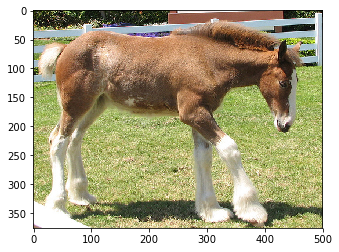

In [4]:
%matplotlib inline
from matplotlib.pyplot import imshow
from scipy.misc import imread
imshow(imread("/opt/bigdl/act/notebooks/part4/image-net/158516268_796c3e047d.jpg"))